In [1]:
!pip install astra-toolbox
!pip install pyellipsoid

In [2]:
from feldkamp import Feldkamp
import numpy as np
from create_dataset import get_data, to_tif, to_np
import os

In [3]:
num_projections = 11
tif_path = './dataset/tif/'
np_path = './dataset/np/'
dim = (2, 256, 256, 50)
num_vols = 25

In [4]:
if not os.path.exists(np_path):
    os.makedirs(np_path)
if not os.path.exists(tif_path):
    os.makedirs(tif_path)
if not os.listdir(np_path):
    ellipsoid_data = get_data(dim)
    to_tif(ellipsoid_data, tif_path, type='xy')
    to_np(ellipsoid_data, np_path)

In [5]:
path = './dataset/tif/'
Feldkamp = Feldkamp(path)

Coordinate della sorgente ottenute:
         x          y          z
   -207.06    -128.00     797.74
   -166.33    -128.00     807.52
   -125.15    -128.00     815.15
    -83.62    -128.00     820.62
    -41.87    -128.00     823.90
      0.00    -128.00     825.00
     41.87    -128.00     823.90
     83.62    -128.00     820.62
    125.15    -128.00     815.15
    166.33    -128.00     807.52
    207.06    -128.00     797.74


Volume: ellipsoid_dataset_0_xy.tif, Rumore: 0.0:   0%|          | 0/4 [00:00<?, ?volume/s]
Proiezioni: (500, 11, 700):  67%|██████▋   | 2/3 [00:00<00:00,  9.75it/s]
                                                                         
Volume: (50, 256, 256), tempo: 0.03s:  67%|██████▋   | 2/3 [00:00<00:00,  7.92it/s]

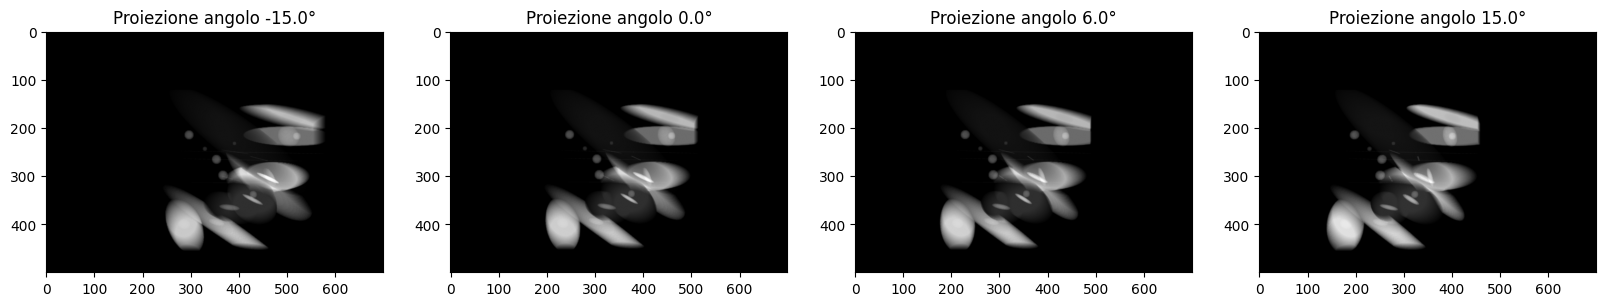

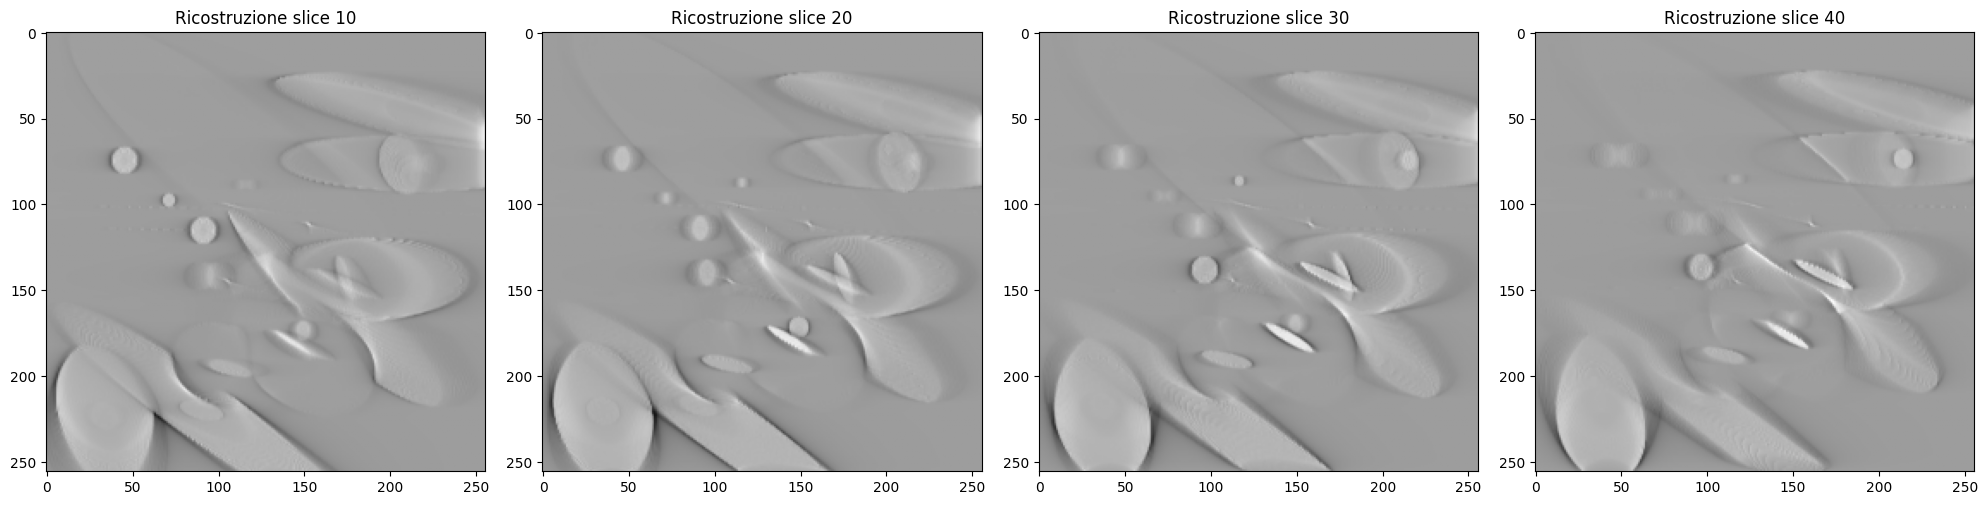


Rumore aggiunto: 0.2: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]
                                                                   
Volume: (50, 256, 256), tempo: 0.06s:  67%|██████▋   | 2/3 [00:00<00:00,  3.52it/s]

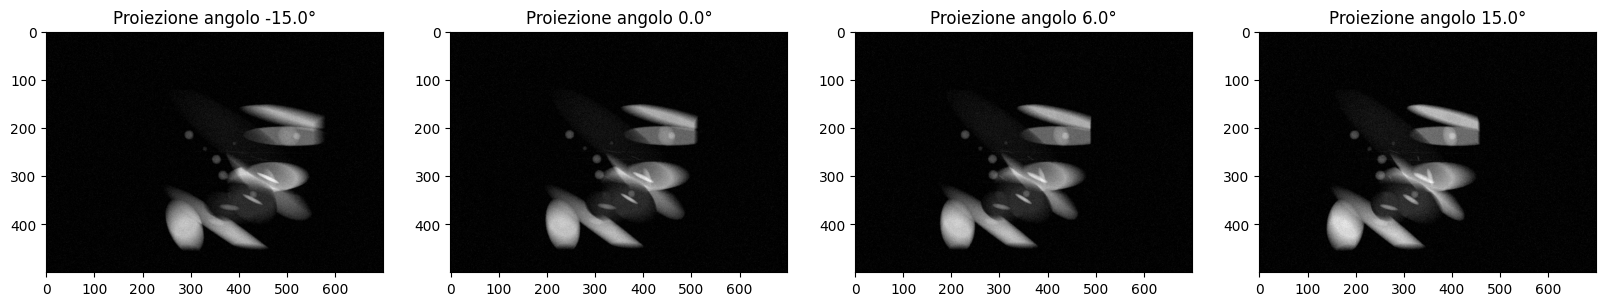

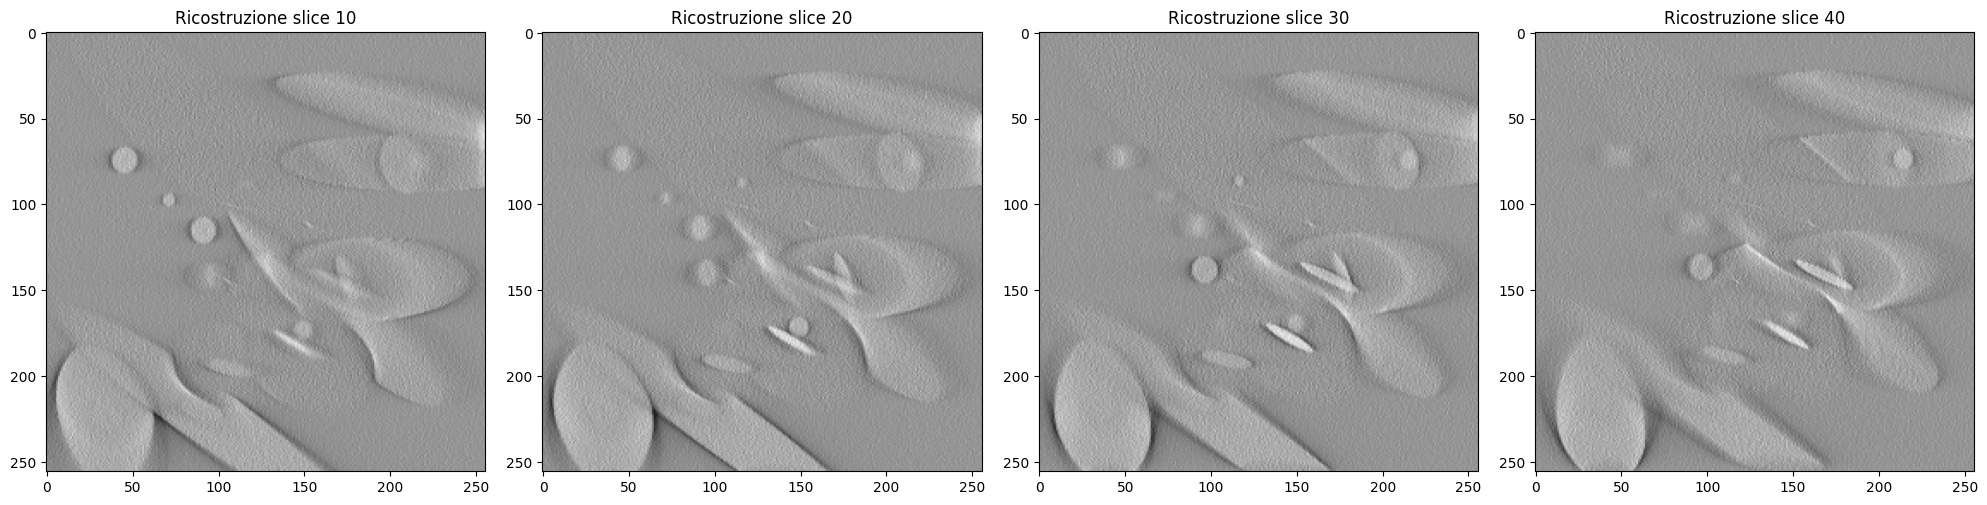


Proiezioni: (500, 11, 700):  67%|██████▋   | 2/3 [00:00<00:00, 36.75it/s]
                                                                         
Volume: (50, 256, 256), tempo: 0.05s:  67%|██████▋   | 2/3 [00:00<00:00,  3.60it/s]

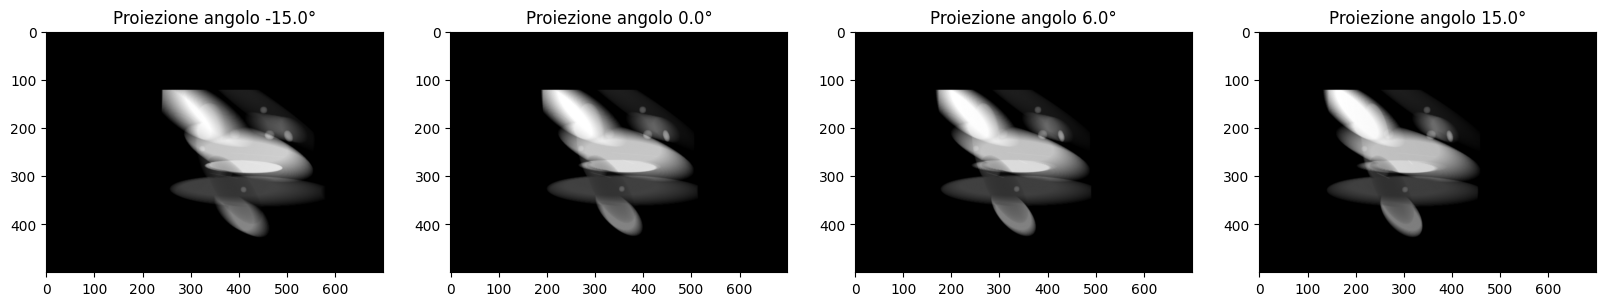

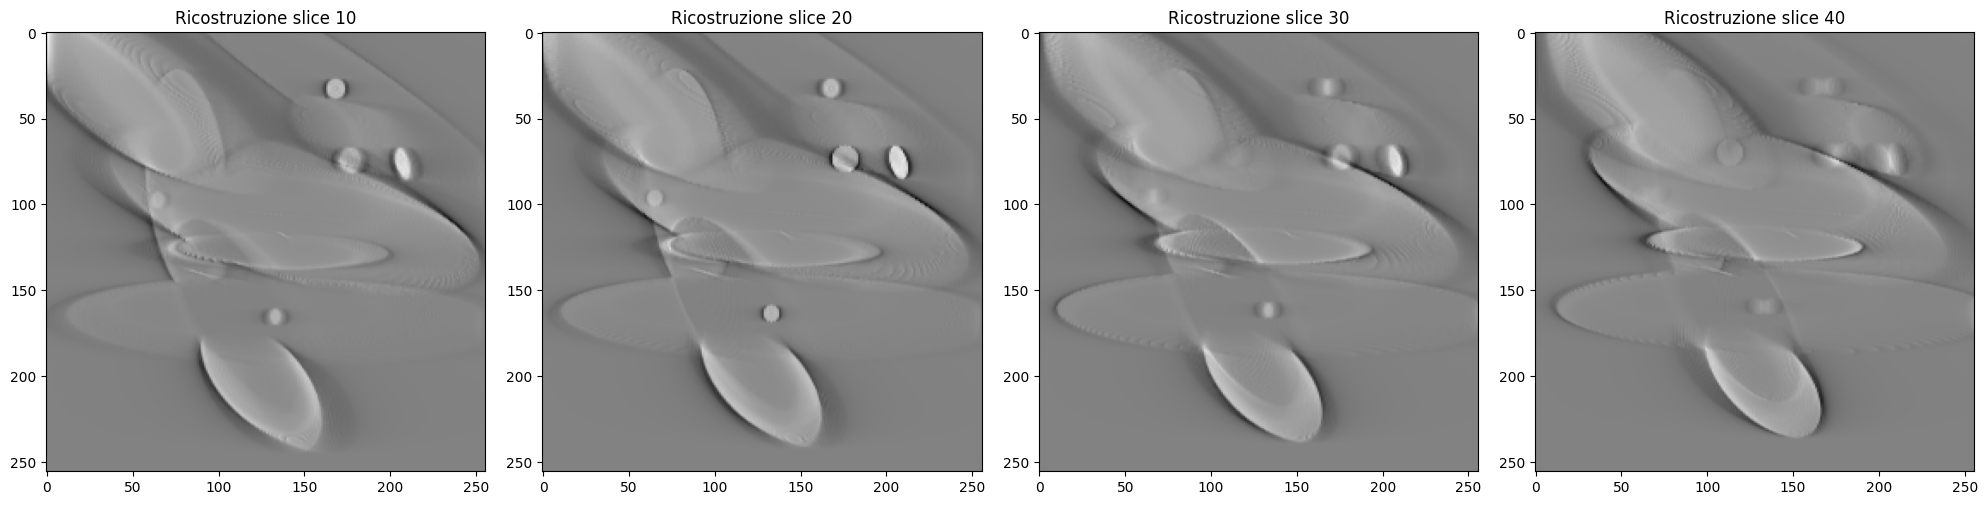


Rumore aggiunto: 0.2: 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]
                                                                   
Volume: (50, 256, 256), tempo: 0.06s:  67%|██████▋   | 2/3 [00:00<00:00,  4.31it/s]

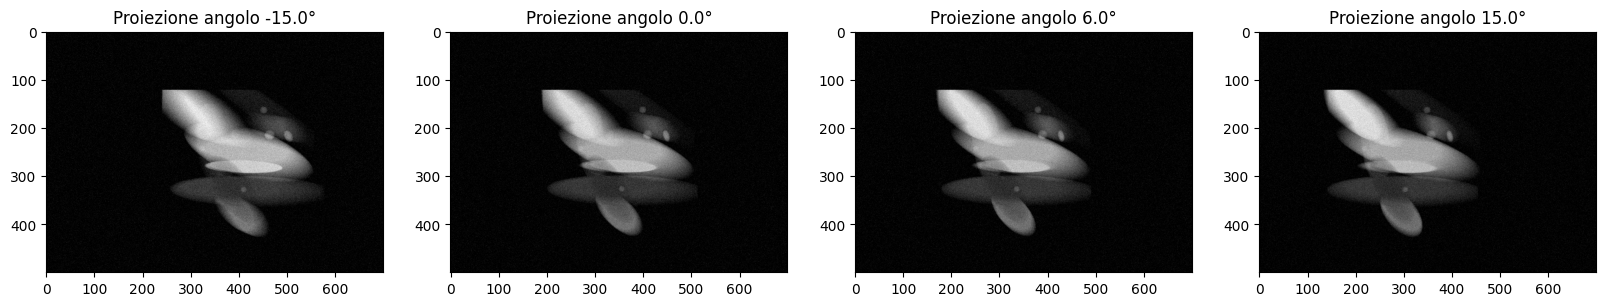

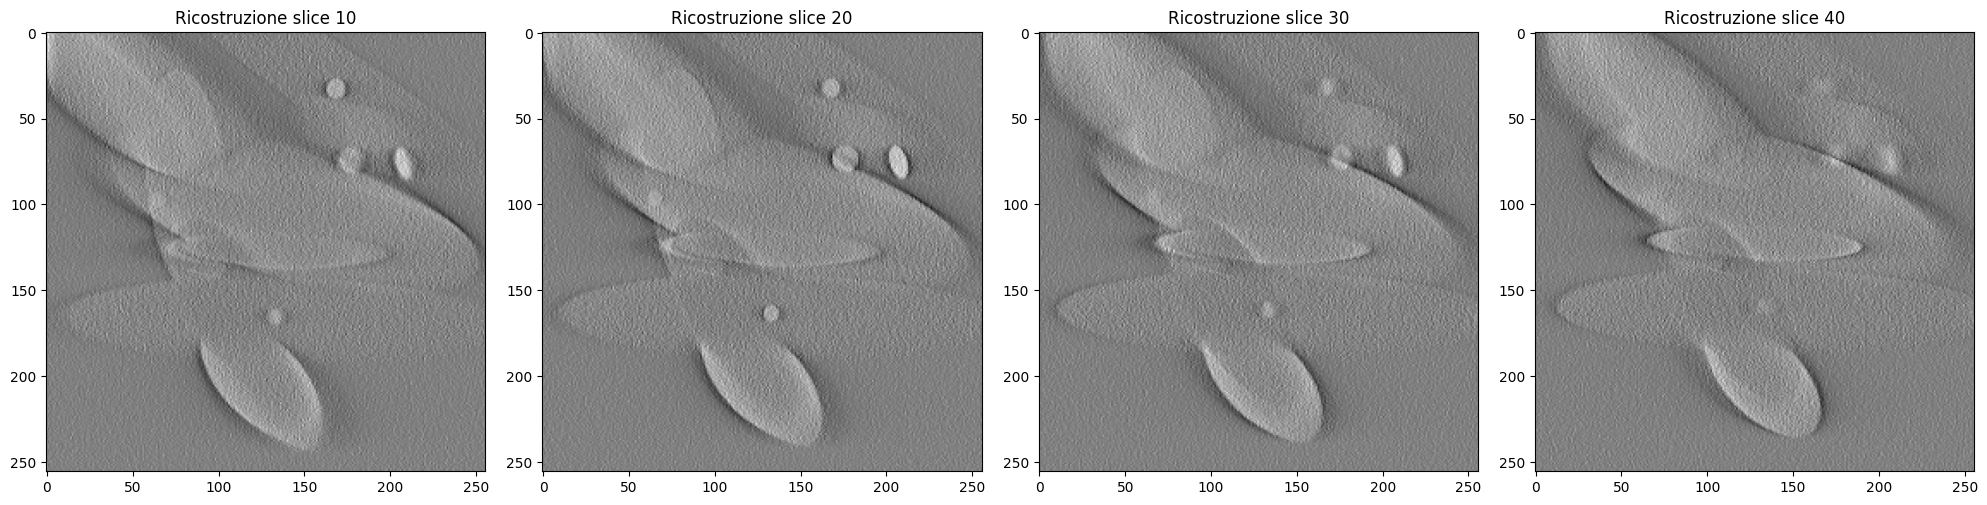


Salvataggio in reconstructions.npz: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]


Riepilogo elaborazione:
- Volumi elaborati: 2
- Livelli di rumore: [0.0, 0.2]
- Totale ricostruzioni: 4
- Dimensione volumi: (50, 256, 256)
- Memoria utilizzata: 50.00 MB


In [6]:
Feldkamp.run(noise_levels=[0.00, 0.20])

In [7]:
import numpy as np
import matplotlib.pyplot as plt


data = np.load('reconstructions.npz')


print("Chiavi disponibili nel file:", data.files)


volumes = data['volumes']
print("Shape dei volumi:", volumes.shape)

Chiavi disponibili nel file: ['volumes', 'volume_name', 'noise_level', 'metadata']
Shape dei volumi: (4, 50, 256, 256)


In [8]:
from metrics import *

data = np.load('reconstructions.npz')
ground_truth = np.load('dataset/np/ellipsoid_dataset.npy')

volumes = data['volumes']
noise_level = data['noise_level']

noised = np.where(noise_level == 0.00)[0]

reconstruction = volumes[noised]
ground_truth = np.transpose(ground_truth, (0, 3, 1, 2))
#reconstruction = np.transpose(reconstruction, (0, 2, 3, 1))

print(f'reconstruction shape: {reconstruction.shape}')
print(f'ground_truth shape: {ground_truth.shape}')


re = rel_err(ground_truth, reconstruction)
psnr = PSNR(ground_truth, reconstruction)
rmse = RMSE(ground_truth, reconstruction)
ssim = SSIM(ground_truth, reconstruction)

print(f're: {re}, psnr: {psnr}, rmse: {rmse}, ssim: {ssim}')

reconstruction shape: (2, 50, 256, 256)
ground_truth shape: (2, 50, 256, 256)
re: 0.8501242399215698, psnr: 11.468935594151088, rmse: 0.26716890931129456, ssim: 0.22770705151783216


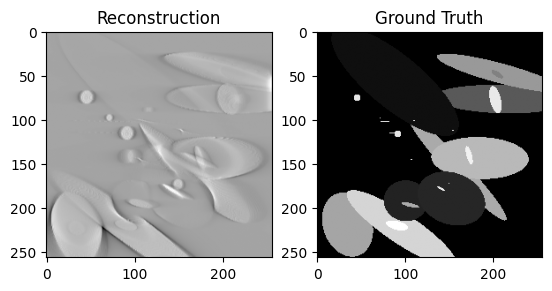

In [14]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1); plt.imshow(reconstruction[0, 13], cmap='grey'); plt.title("Reconstruction")
plt.subplot(1, 2, 2); plt.imshow(ground_truth[0, 13], cmap='grey'); plt.title("Ground Truth")
plt.show()

In [10]:
import torch
from sklearn.model_selection import train_test_split

def normalize(vol):
  return (vol - vol.min()) / (vol.max() - vol.min())

reconstruction = np.array([normalize(vol) for vol in reconstruction])
ground_truth = np.array([normalize(vol) for vol in ground_truth])

train_reconstruction, test_reconstruction, train_ground_truth, test_ground_truth = train_test_split(reconstruction, ground_truth, test_size=0.2, random_state=42)

train_reconstruction = torch.FloatTensor(train_reconstruction).unsqueeze(1)  # [N, 1, D, H, W]
train_ground_truth = torch.FloatTensor(train_ground_truth).unsqueeze(1)
test_reconstruction = torch.FloatTensor(test_reconstruction).unsqueeze(1)
test_ground_truth = torch.FloatTensor(test_ground_truth).unsqueeze(1)

print(f'train_reconstruction shape: {train_reconstruction.shape}')
print(f'test_reconstruction shape: {test_reconstruction.shape}')
print(f'train_ground_truth shape: {train_ground_truth.shape}')
print(f'test_ground_truth shape: {test_ground_truth.shape}')


train_reconstruction shape: torch.Size([1, 1, 50, 256, 256])
test_reconstruction shape: torch.Size([1, 1, 50, 256, 256])
train_ground_truth shape: torch.Size([1, 1, 50, 256, 256])
test_ground_truth shape: torch.Size([1, 1, 50, 256, 256])


In [11]:
from torch import nn
from torch.nn import functional as F

class ResidualBlock3D(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(in_channels)
        self.conv2 = nn.Conv3d(in_channels, in_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(in_channels)

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return F.relu(out)

class ResUnet3D(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv3d(in_channels, 64, kernel_size=3, padding=1),
            ResidualBlock3D(64)
        )
        self.enc2 = nn.Sequential(
            nn.MaxPool3d(2),
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            ResidualBlock3D(128)
        )
        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.MaxPool3d(2),
            nn.Conv3d(128, 256, kernel_size=3, padding=1),
            ResidualBlock3D(256)
        )
        # Decoder
        self.up1 = nn.ConvTranspose3d(256, 128, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock3D(128)
        self.up2 = nn.ConvTranspose3d(128, 64, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock3D(64)
        # Output
        self.out = nn.Conv3d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        b = self.bottleneck(e2)
        d1 = self.up1(b)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)
        d2 = self.up2(d1)
        d2 = torch.cat([d2, e1], dim=1)
        d2 = self.dec2(d2)
        return torch.sigmoid(self.out(d2))

model = ResUnet3D()

In [12]:
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

train_dataset = TensorDataset(train_reconstruction, train_ground_truth)
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_dataset = TensorDataset(test_reconstruction, test_ground_truth)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(10):
    # Training
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()

    print(f"Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(test_loader):.4f}")

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 24 but got size 25 for tensor number 1 in the list.

In [ ]:
model.eval()
with torch.no_grad():
    # Select a test volume
    test_input = test_recon[0:1].to(device)
    test_output = model(test_input)
    test_target = test_gt[0:1].to(device)

    # Convert to numpy
    input_slice = test_input.squeeze().cpu().numpy()[25]  # Middle slice (D/2)
    output_slice = test_output.squeeze().cpu().numpy()[25]
    target_slice = test_target.squeeze().cpu().numpy()[25]

    # Compute metrics
    from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
    p = psnr(target_slice, output_slice, data_range=1.0)
    s = ssim(target_slice, output_slice, data_range=1.0)

    print(f"PSNR: {p:.2f} dB, SSIM: {s:.4f}")

    # Plot
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(input_slice, cmap='gray')
    plt.title("Noisy Input")
    plt.subplot(1, 3, 2)
    plt.imshow(output_slice, cmap='gray')
    plt.title("Denoised Output")
    plt.subplot(1, 3, 3)
    plt.imshow(target_slice, cmap='gray')
    plt.title("Ground Truth")
    plt.show()